# Analysing mock datasets

In [8]:
# packages

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import pandas as pd
import os
from itertools import combinations

import sys
sys.path.append("../src")

from analysis import *
from inference import *

In [9]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(l, key=alphanum_key)

In [10]:
path = "../experiment_outputs/perturb_meas_0.1/"

In [11]:
n_sp = 5

infer_out_files = [i for i in os.listdir(f"{path}/inference") if f"{n_sp}_sp" in i]
infer_out_files = natural_sort(infer_out_files)
metadatafiles = [f"metadata{i.split('infer_out_')[1][:-3]}txt" for i in infer_out_files]

In [12]:
infer_out_files

['infer_out_5_sp0_env_noise0.1.csv',
 'infer_out_5_sp1_env_noise0.1.csv',
 'infer_out_5_sp2_env_noise0.1.csv',
 'infer_out_5_sp3_env_noise0.1.csv',
 'infer_out_5_sp4_env_noise0.1.csv',
 'infer_out_5_sp5_env_noise0.1.csv',
 'infer_out_5_sp6_env_noise0.1.csv',
 'infer_out_5_sp7_env_noise0.1.csv',
 'infer_out_5_sp8_env_noise0.1.csv',
 'infer_out_5_sp9_env_noise0.1.csv']

In [13]:
metadict_list = []
for file in metadatafiles:
    metatext = open(f"{path}/metadata/"+file, "r").read().split("\n")
    metadict_list.append(get_meta(metatext))

metadict = metadict_list[0]

In [14]:
infer_out_list = [pd.read_csv(f"{path}/inference/{file}", index_col=0) for file in infer_out_files]
infer_out_all = pd.concat(infer_out_list)

In [15]:
infer_out_all.columns

Index(['n_init_cond', 'init_cond_idx', 't_samp_dist_idx', 'measurement_noise',
       'r1', 'r2', 'r3', 'r4', 'r5', 'A1,1', 'A1,2', 'A1,3', 'A1,4', 'A1,5',
       'A2,1', 'A2,2', 'A2,3', 'A2,4', 'A2,5', 'A3,1', 'A3,2', 'A3,3', 'A3,4',
       'A3,5', 'A4,1', 'A4,2', 'A4,3', 'A4,4', 'A4,5', 'A5,1', 'A5,2', 'A5,3',
       'A5,4', 'A5,5', 'MSPD', 'CSR', 'ES'],
      dtype='object')

In [16]:
n_sp = len([i for i in infer_out_all.columns if i[0]=="r"])

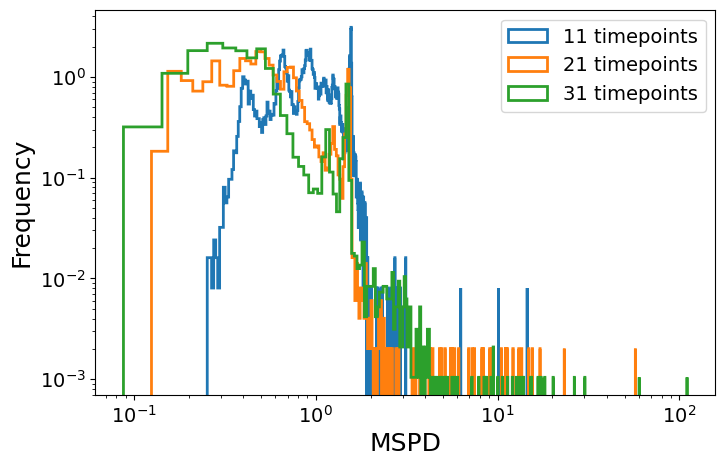

In [17]:
# MSPD frequency
plt.figure(figsize=(8,5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].MSPD.values, 2000,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints", 
             lw=2, density=True)
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("MSPD", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale("log")
plt.yscale("log")
plt.show()

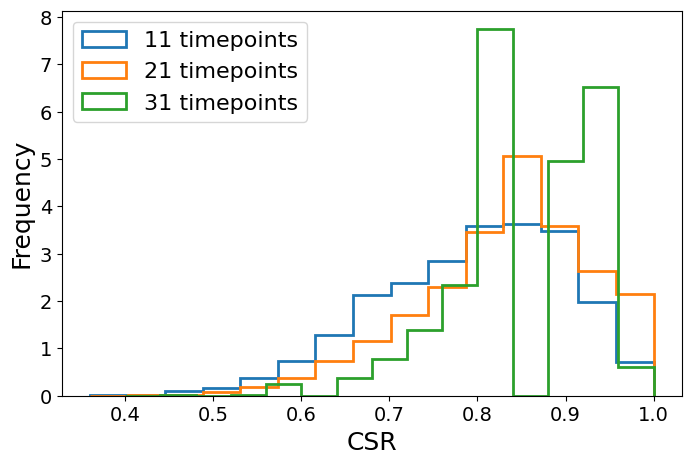

In [18]:
# CSR frequency over n_tpoints

plt.figure(figsize=(8, 5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].CSR.values, 15,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("CSR", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

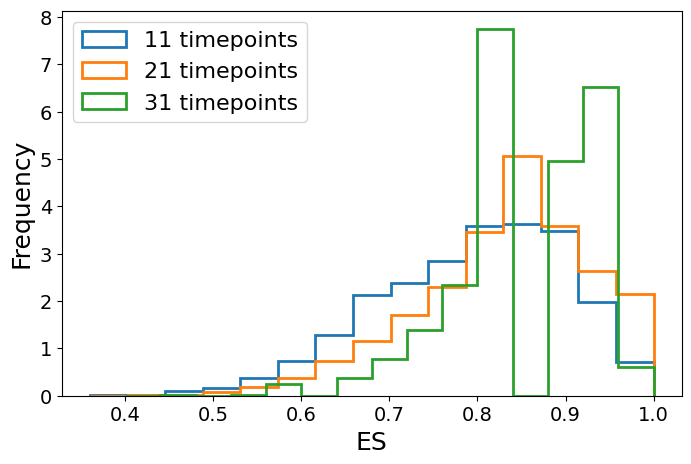

In [19]:
# ES frequency over n_tpoints

plt.figure(figsize=(8, 5))
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    plt.hist(infer_out_all[infer_out_all.t_samp_dist_idx==t_samp].ES.values, 15,
             histtype="step", label=f"{metadict['n_tpoints'][int(t_samp)]} timepoints",
             lw=2, density=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("ES", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [20]:
# Difference between CSR and ES scores
(infer_out_all.CSR!=infer_out_all.ES).sum()

0

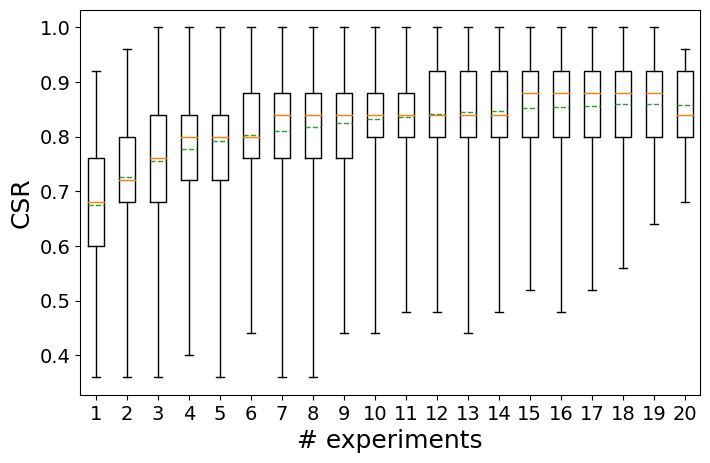

In [21]:
# CSR boxplots over # of experiments
CSR = [infer_out_all[infer_out_all.n_init_cond==i]["CSR"].values \
        for i in infer_out_all.n_init_cond.unique()]

plt.figure(figsize=(8,5))
plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("CSR", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


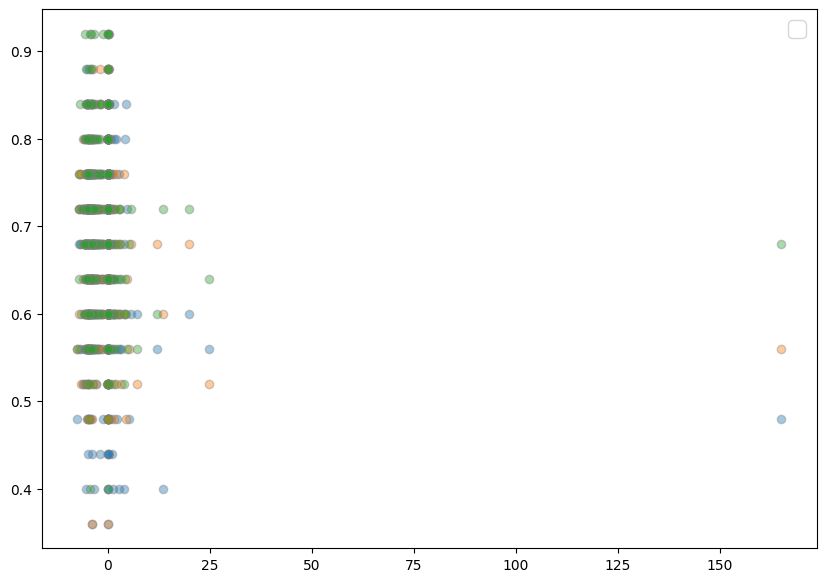

In [44]:
plt.figure(figsize=(10,7))

for j in range(len(metadict["n_tpoints"])):
    init_cond_msd = []
    csr = []
    for k in range(len(infer_out_list)):
        df_tmp = infer_out_list[k][(infer_out_list[k][["t_samp_dist_idx", "n_init_cond"]]==[j,1]).all(axis=1)]
        
        init_cond_idx = [int(re.findall("([0-9]+).0", i)[0]) for i in df_tmp.init_cond_idx]
        init_cond = metadict_list[k]["init_cond"][init_cond_idx]

        p = metadict_list[k]["parameters"]
        r = p[:n_sp]
        A = p[n_sp:].reshape((n_sp, n_sp))
        x_eq = -np.linalg.inv(A)@r

        init_cond_msd.append(((init_cond-x_eq)**2).mean(axis=1))
        csr.append(df_tmp.CSR.values)

        # plt.scatter(np.log(((init_cond-x_eq)**2).mean(axis=1)), df_tmp.CSR, 
        #             facecolors=f"C{j}", alpha=0.4, edgecolors="gray")

        plt.scatter(((init_cond-x_eq)**2).mean(axis=1), df_tmp.CSR, 
                    facecolors=f"C{j}", alpha=0.4, edgecolors="gray")

    # init_cond_msd = np.concatenate(init_cond_msd)
    # csr = np.concatenate(csr)

    # reg = lm.LinearRegression()
    # reg.fit(np.log(init_cond_msd).reshape((-1,1)), csr)
    # plt.plot([np.log(init_cond_msd).min(), np.log(init_cond_msd).max()], 
    #          reg.predict([[np.log(init_cond_msd).min()], [np.log(init_cond_msd).max()]]),
    #          ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel()
plt.legend(fontsize=16)
plt.show()

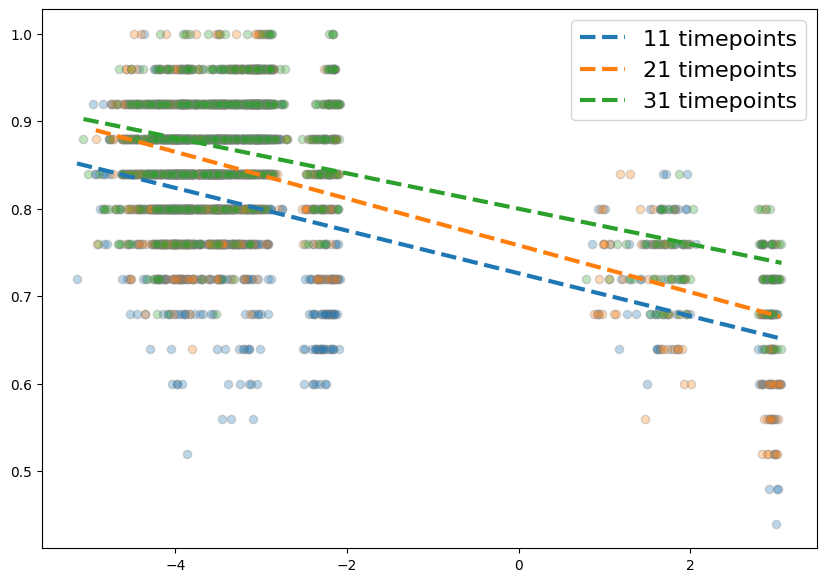

In [30]:
plt.figure(figsize=(10,7))

for j in range(len(metadict["n_tpoints"])):
    init_cond_var = []
    csr = []
    for k in range(len(infer_out_list)):
        df_tmp = infer_out_list[k][(infer_out_list[k][["t_samp_dist_idx", "n_init_cond"]]==[j,10]).all(axis=1)]
        
        init_cond_idx = [[int(m) for m in re.findall("([0-9]+).0", i)] for i in df_tmp.init_cond_idx.values]
        
        for l in range(len(init_cond_idx)):
            init_cond = metadict_list[k]["init_cond"][init_cond_idx[l]]

            init_cond_var.append(init_cond)
            csr.append(df_tmp.CSR.values[l])

    init_cond_var = np.array(init_cond_var).var(axis=1).mean(axis=1)
    csr = np.array(csr)

    plt.scatter(np.log(init_cond_var), csr, 
                facecolors=f"C{j}", alpha=0.3, edgecolors="gray")

    reg = lm.LinearRegression()
    reg.fit(np.log(init_cond_var).reshape((-1,1)), csr)
    plt.plot([np.log(init_cond_var).min(), np.log(init_cond_var).max()], 
             reg.predict([[np.log(init_cond_var).min()], [np.log(init_cond_var).max()]]),
             ls="--", lw=3, c=f"C{j}", label=f"{metadict['n_tpoints'][j]} timepoints")

# plt.xlabel()
plt.legend(fontsize=16)
plt.show()

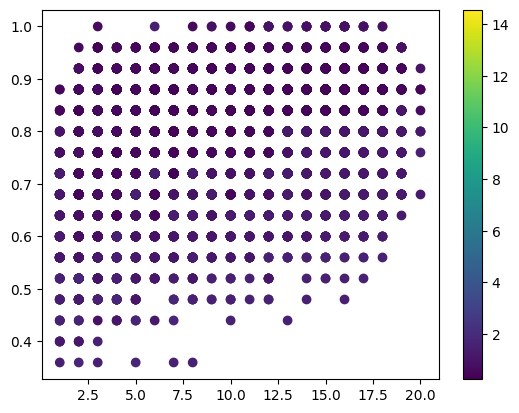

In [31]:
df_tmp = infer_out_all[infer_out_all.t_samp_dist_idx==0]
plt.scatter(df_tmp.n_init_cond, df_tmp.CSR, c=df_tmp.MSPD)
plt.colorbar()
plt.show()

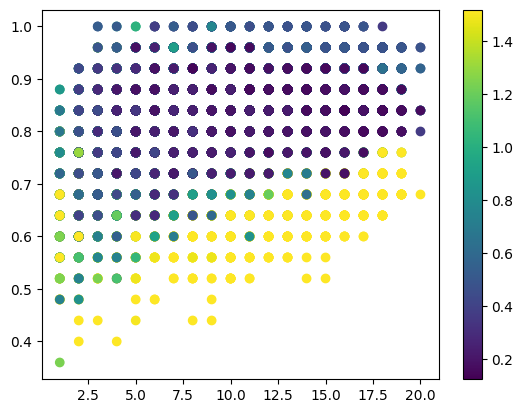

In [32]:
df_tmp = infer_out_all[infer_out_all.t_samp_dist_idx==1]
plt.scatter(df_tmp.n_init_cond, df_tmp.CSR, c=df_tmp.MSPD, vmax=np.percentile(df_tmp.MSPD, 95))
plt.colorbar()
plt.show()

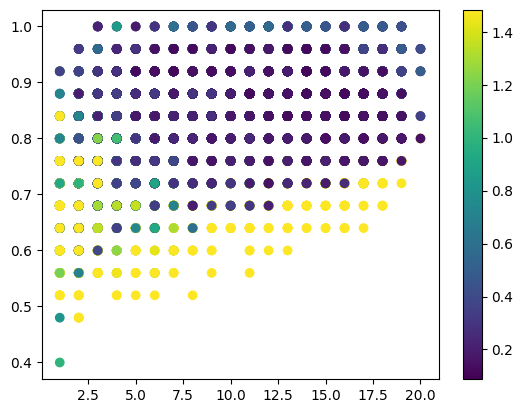

In [33]:
df_tmp = infer_out_all[infer_out_all.t_samp_dist_idx==2]
plt.scatter(df_tmp.n_init_cond, df_tmp.CSR, c=df_tmp.MSPD, vmax=np.percentile(df_tmp.MSPD, 95))
plt.colorbar()
plt.show()

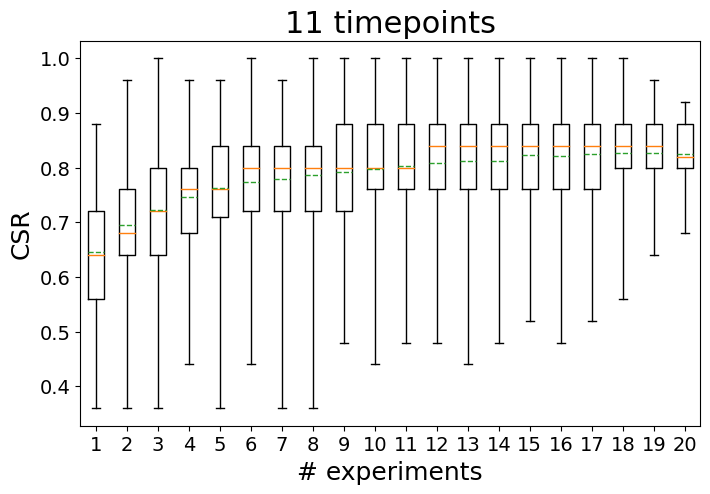

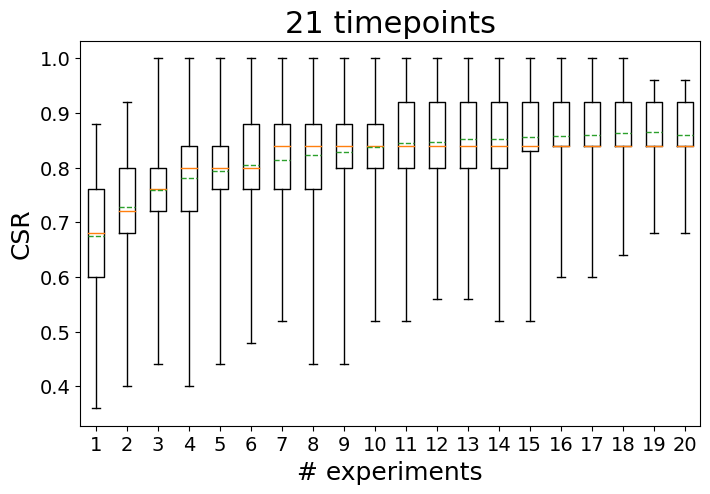

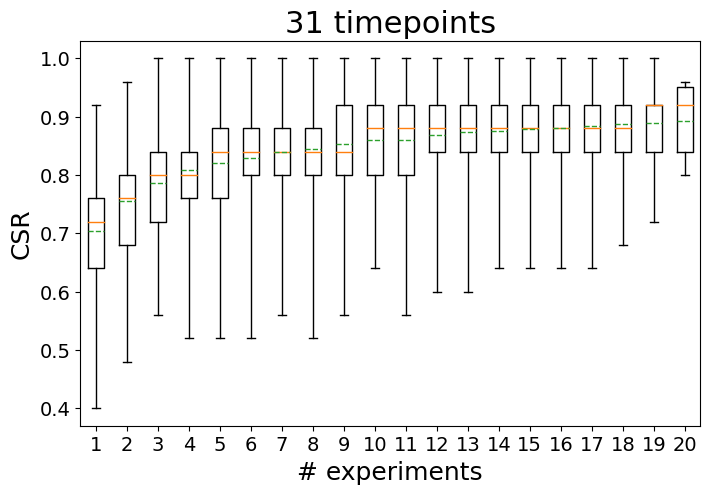

In [34]:
# CSR boxplot over # of experiments, by n_tpoints
for t_samp in infer_out_all.t_samp_dist_idx.unique():
    CSR = [infer_out_all[(infer_out_all[["n_init_cond", "t_samp_dist_idx"]]==[i,t_samp]).all(axis=1)]["CSR"].values \
            for i in infer_out_all.n_init_cond.unique()]

    plt.figure(figsize=(8,5))
    plt.title(f"{metadict['n_tpoints'][int(t_samp)]} timepoints", fontsize=22)
    plt.boxplot(CSR, whis=(0, 100), meanline=True, showmeans=True)
    plt.xlabel("# experiments", fontsize=18)
    plt.ylabel("CSR", fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

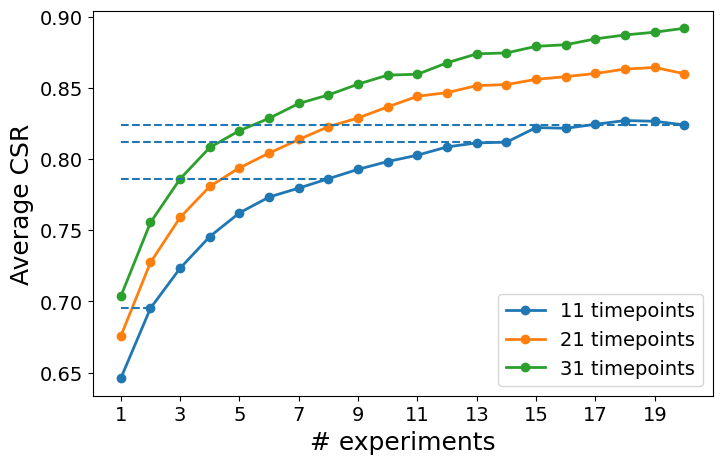

In [35]:
# average CSR over time
avgCSR = np.zeros((len(metadict["t_samp"]), len(metadict["init_cond"])))
for i in range(len(infer_out_all.t_samp_dist_idx.unique())):
    t_samp = infer_out_all.t_samp_dist_idx.unique()[i]
    for j in range(len(infer_out_all.n_init_cond.unique())):
        n_init_cond = infer_out_all.n_init_cond.unique()[j]
        avgCSR[i,j] = infer_out_all[(infer_out_all[["t_samp_dist_idx", "n_init_cond"]]==[t_samp, n_init_cond]).all(axis=1)]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in metadict["n_tpoints"]]
plt.figure(figsize=(8,5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1), avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0,i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.show()

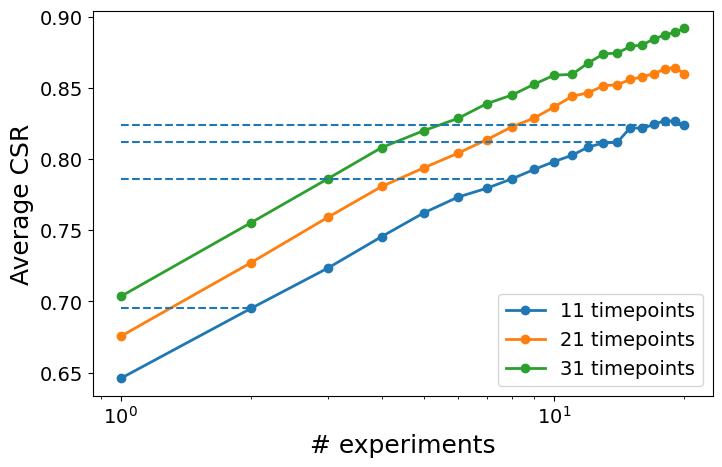

In [36]:
# average CSR over time
avgCSR = np.zeros((len(metadict["t_samp"]), len(metadict["init_cond"])))
for i in range(len(infer_out_all.t_samp_dist_idx.unique())):
    t_samp = infer_out_all.t_samp_dist_idx.unique()[i]
    for j in range(len(infer_out_all.n_init_cond.unique())):
        n_init_cond = infer_out_all.n_init_cond.unique()[j]
        avgCSR[i,j] = infer_out_all[(infer_out_all[["t_samp_dist_idx", "n_init_cond"]]==[t_samp, n_init_cond]).all(axis=1)]["CSR"].values.mean()

labels = [f"{i} timepoints" for i in metadict["n_tpoints"]]
plt.figure(figsize=(8,5))
for i in range(len(avgCSR)):
    plt.plot(np.arange(1, len(avgCSR[i])+1), avgCSR[i], "-o", lw=2, label=labels[i])
plt.legend(loc="lower right", fontsize=14)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("Average CSR", fontsize=18)
plt.xticks(np.arange(1, len(CSR)+1, 2), fontsize=14)
plt.yticks(fontsize=14)
for i in range(1, len(avgCSR[0]), 6):
    plt.hlines(avgCSR[0,i], 1, i+1, color="C0", ls="--")
    # plt.hlines(avgCSR[1,i], 1, i+1, color="C1")
plt.xscale("log")
plt.show()

In [37]:
# CSR ratios

tpoints_ratio01 = []
CSR_ratio01 = []
tpoints_ratio02 = []
CSR_ratio02 = []
tpoints_ratio12 = []
CSR_ratio12 = []

for i in range(len(avgCSR[0])):
    for j in range(len(avgCSR[1])):
        tpoints_ratio01.append(20*(j+1)/(10*(i+1)))
        CSR_ratio01.append(avgCSR[1,j]/avgCSR[0,i])
        tpoints_ratio02.append(30*(j+1)/(10*(i+1)))
        CSR_ratio02.append(avgCSR[2,j]/avgCSR[0,i])
        tpoints_ratio12.append(30*(j+1)/(20*(i+1)))
        CSR_ratio12.append(avgCSR[2,j]/avgCSR[1,i])

tpoints_ratio01 = np.array(tpoints_ratio01)
CSR_ratio01 = np.array(CSR_ratio01)
tpoints_ratio02 = np.array(tpoints_ratio02)
CSR_ratio02 = np.array(CSR_ratio02)
tpoints_ratio12 = np.array(tpoints_ratio12)
CSR_ratio12 = np.array(CSR_ratio12)

tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))

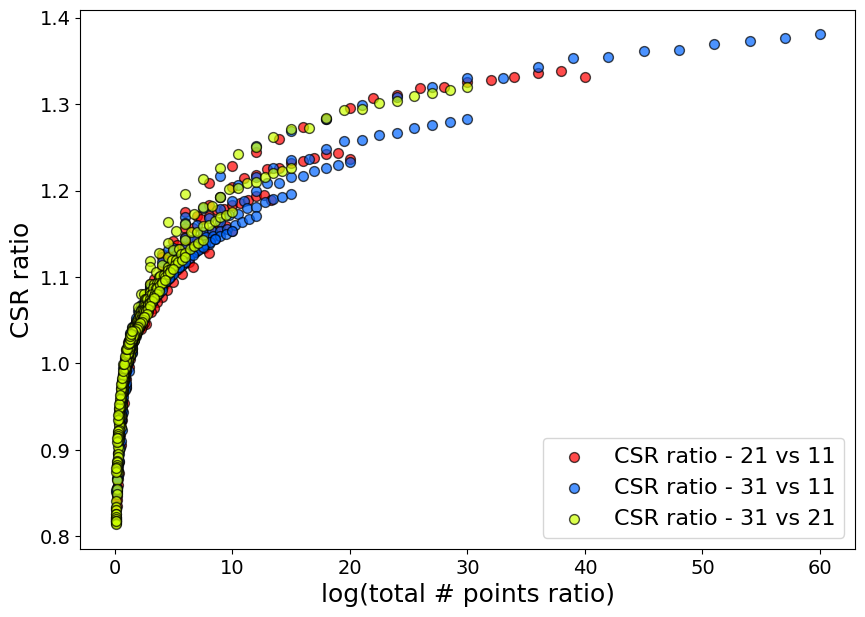

In [38]:
# CSR_ratio vs tpoints ratio
plt.figure(figsize=(10,7))

#01 ---
plt.scatter(tpoints_ratio01, CSR_ratio01, facecolors=hsv_to_rgb((0,1,1)), edgecolors="k", 
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)

# 02 ---
plt.scatter(tpoints_ratio02, CSR_ratio02, facecolors=hsv_to_rgb((0.6,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)

#12 ---
plt.scatter(tpoints_ratio12, CSR_ratio12, facecolors=hsv_to_rgb((0.2,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

20 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9700257332634932
intercept = 0.99206, slope = 0.08353

--------------------------------
30 vs 10 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9684457233897925
intercept = 0.98906, slope = 0.08379

--------------------------------
30 vs 20 timepoints:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.96836247163505
intercept = 1.00142, slope = 0.07997

--------------------------------
all ratios:
CSR_ratio vs log(tpoints_ratio): R2 score = 0.9680062286818557
intercept = 0.99521, slope = 0.08160


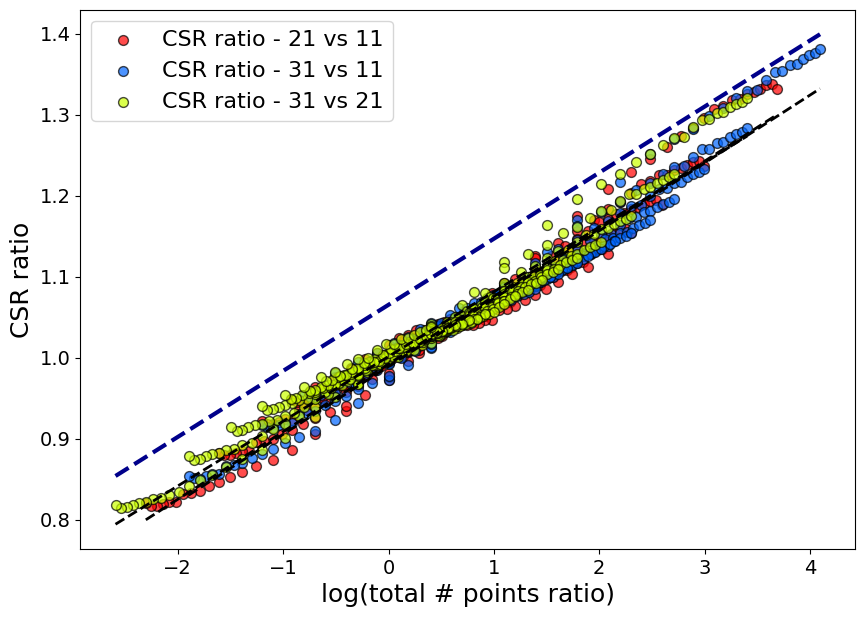

In [39]:
# CSR_ratio vs log(tpoints ratio)
plt.figure(figsize=(10,7))

#01 ---
plt.scatter(np.log(tpoints_ratio01), CSR_ratio01, facecolors=hsv_to_rgb((0,1,1)), edgecolors="k", 
            label="CSR ratio - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1,1)), CSR_ratio01)
x_ext = np.array([np.min(np.log(tpoints_ratio01)), np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio01).reshape((-1,1)), CSR_ratio01))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), CSR_ratio02, facecolors=hsv_to_rgb((0.6,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1,1)), CSR_ratio02)
x_ext = np.array([np.min(np.log(tpoints_ratio02)), np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio02).reshape((-1,1)), CSR_ratio02))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

#12 ---
plt.scatter(np.log(tpoints_ratio12), CSR_ratio12, facecolors=hsv_to_rgb((0.2,1,1)), edgecolors="k", 
            label="CSR ratio - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1,1)), CSR_ratio12)
x_ext = np.array([np.min(np.log(tpoints_ratio12)), np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio12).reshape((-1,1)), CSR_ratio12))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("CSR_ratio vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

20 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.976608894349676
intercept = -0.01039, slope = 0.07946

--------------------------------
30 vs 10 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9782539297292739
intercept = -0.01063, slope = 0.07718

--------------------------------
30 vs 20 timepoints:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9779796183415417
intercept = -0.00177, slope = 0.07704

--------------------------------
all ratios:
log(CSR_ratio) vs log(tpoints_ratio): R2 score = 0.9765026929111014
intercept = -0.00704, slope = 0.07711


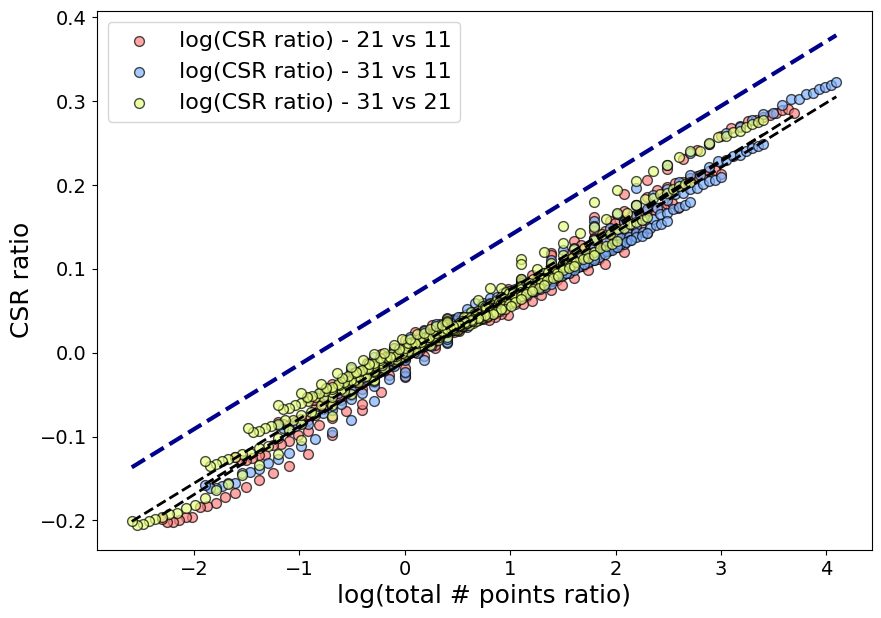

In [40]:
# log(CSR_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

#01 ---
plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01), facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 21 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio01).reshape((-1,1)), np.log(CSR_ratio01))
x_ext = np.array([np.min(np.log(tpoints_ratio01)), np.max(np.log(tpoints_ratio01))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("20 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio01).reshape((-1,1)), np.log(CSR_ratio01)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

# 02 ---
plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02), facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 31 vs 11", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio02).reshape((-1,1)), np.log(CSR_ratio02))
x_ext = np.array([np.min(np.log(tpoints_ratio02)), np.max(np.log(tpoints_ratio02))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 10 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio02).reshape((-1,1)), np.log(CSR_ratio02)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

#12 ---
plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12), facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", 
            label="log(CSR ratio) - 31 vs 21", s=50, alpha=0.7)
reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio12).reshape((-1,1)), np.log(CSR_ratio12))
x_ext = np.array([np.min(np.log(tpoints_ratio12)), np.max(np.log(tpoints_ratio12))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1))), c="k", lw=2, ls="--")

print("\n--------------------------------")
print("30 vs 20 timepoints:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio12).reshape((-1,1)), np.log(CSR_ratio12)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

reg = lm.LinearRegression()
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.07, c="darkblue", lw=3, ls="--")

print("\n--------------------------------")
print("all ratios:")
print("log(CSR_ratio) vs log(tpoints_ratio): R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio)))
print(f"intercept = {reg.intercept_:.5f}, slope = {reg.coef_[0]:.5f}")

plt.xlabel("log(total # points ratio)", fontsize=18)
plt.ylabel("CSR ratio", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

R2 score = 0.6038589143754988


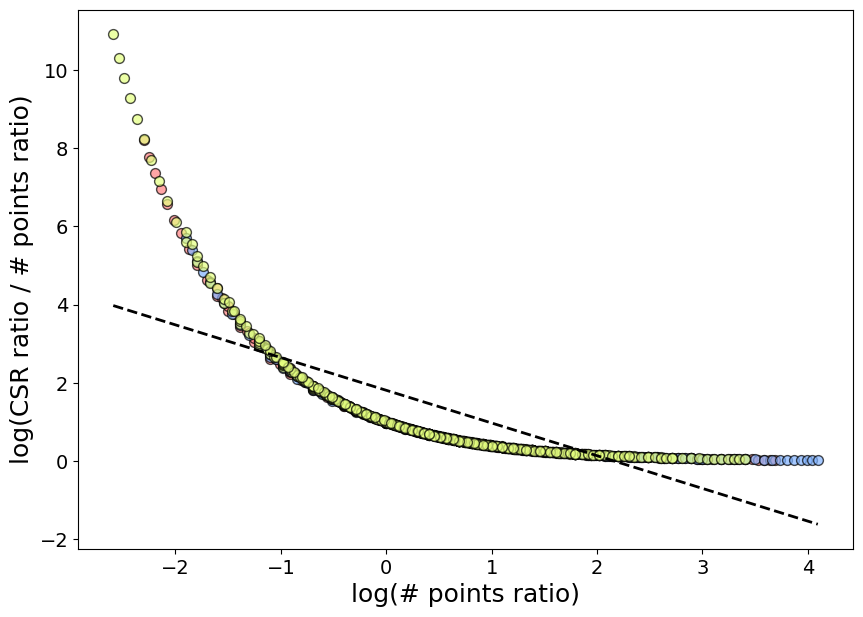

In [41]:
# CSR_ratio/tpoints_ratio vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

plt.scatter(np.log(tpoints_ratio01), CSR_ratio01/tpoints_ratio01, 
            facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), CSR_ratio02/tpoints_ratio02, 
            facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), CSR_ratio12/tpoints_ratio12, 
            facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio/tpoints_ratio)
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), CSR_ratio/tpoints_ratio))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

R2 score = 0.9998320362619106


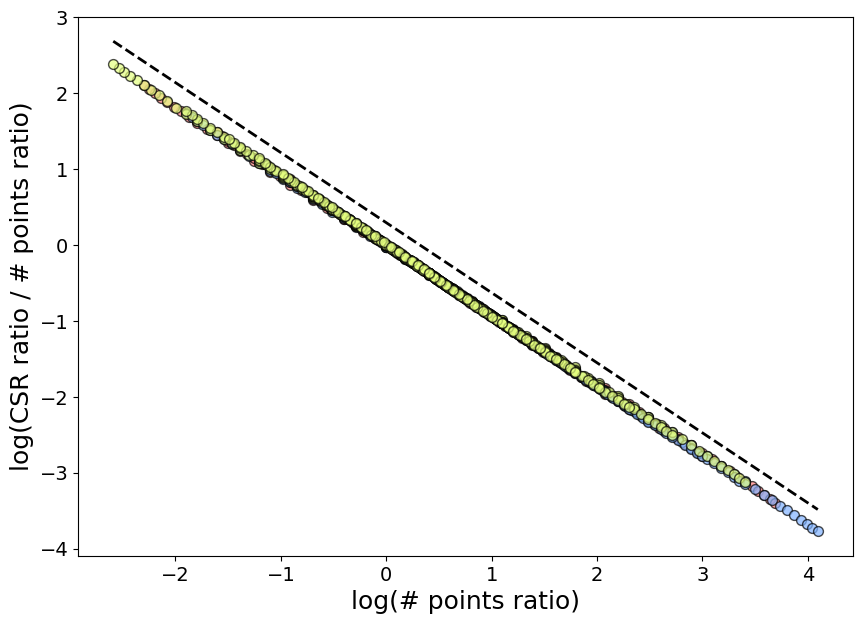

In [42]:
# log(CSR_ratio/tpoints_ratio) vs log(tpoints_ratio)

plt.figure(figsize=(10,7))

plt.scatter(np.log(tpoints_ratio01), np.log(CSR_ratio01/tpoints_ratio01), 
            facecolors=hsv_to_rgb((0,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio02), np.log(CSR_ratio02/tpoints_ratio02), 
            facecolors=hsv_to_rgb((0.6,0.5,1)), edgecolors="k", s=50, alpha=0.7)

plt.scatter(np.log(tpoints_ratio12), np.log(CSR_ratio12/tpoints_ratio12), 
            facecolors=hsv_to_rgb((0.2,0.5,1)), edgecolors="k", s=50, alpha=0.7)

reg = lm.LinearRegression()
tpoints_ratio = np.concatenate((tpoints_ratio01, tpoints_ratio02, tpoints_ratio12))
CSR_ratio = np.concatenate((CSR_ratio01, CSR_ratio02, CSR_ratio12))
reg.fit(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio/tpoints_ratio))
x_ext = np.array([np.min(np.log(tpoints_ratio)), np.max(np.log(tpoints_ratio))])
plt.plot(x_ext, reg.predict(x_ext.reshape((-1,1)))+0.3, c="k", lw=2, ls="--")

print("R2 score =", reg.score(np.log(tpoints_ratio).reshape((-1,1)), np.log(CSR_ratio/tpoints_ratio)))

plt.xlabel("log(# points ratio)", fontsize=18)
plt.ylabel("log(CSR ratio / # points ratio)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

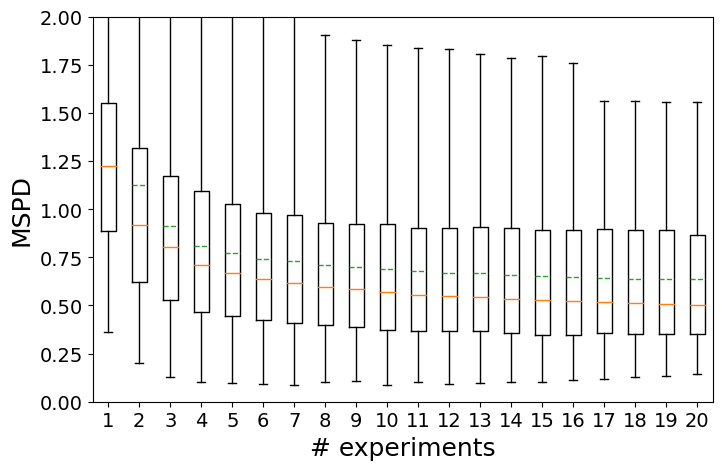

In [43]:
# MSPD boxplots over # of experiments

MSPD = [infer_out_all[infer_out_all.n_init_cond==i]["MSPD"].values \
        for i in infer_out_all.n_init_cond.unique()]

plt.figure(figsize=(8,5))
plt.boxplot(MSPD, whis=(0, 100), meanline=True, showmeans=True)
plt.xlabel("# experiments", fontsize=18)
plt.ylabel("MSPD", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.yscale("log")
plt.ylim(0, 2)
plt.show()